In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import os
os.chdir('../selfplay/')

In [2]:
results = []
first_moves = []
second_moves = []
len_games = []
try:
    i = 0
    while True:
        x = np.load(str(i).zfill(5) + '.npz')
        results.append(x['result'].item())
        first_moves.append(x['moves'][0])
        second_moves.append(x['moves'][1])
        len_games.append(len(x['moves']))
        i += 1
except FileNotFoundError:
    pass
results = np.array(results)
first_moves = np.array(first_moves)
print(f'Got {len(results)} games')

Got 3500 games


In [3]:
data = pd.DataFrame(columns=['Games', 'X', 'O', 'T'])
for i in range(0, len(results), 500):
    hist = np.histogram(results[i:i+500], bins=[1,2,3,4], density=True)[0]
    data = data.append({'Games': f'{i}-{i+500}',
                        'X': hist[0],
                        'O': hist[1],
                        'T': hist[2],
                        }, ignore_index=True)
data = data.melt(id_vars='Games', var_name='Result', value_name='Percent')

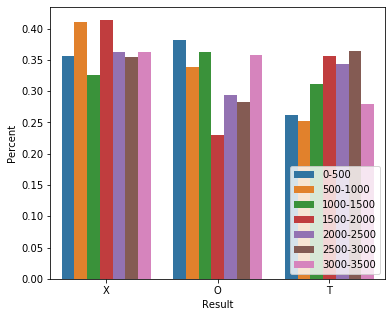

In [4]:
plt.figure(figsize=(6, 5))
sns.barplot(x='Result', y='Percent', hue='Games', data=data, ci=None)
plt.legend(loc='lower right')
plt.show()

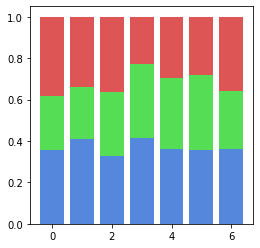

In [5]:
n = len(data) // 3
dat = data['Percent'].to_numpy()
plt.figure(figsize=(4,4))
plt.bar(np.arange(n), dat[0:n]+dat[2*n:]+dat[n:2*n], color='#dd5555')
plt.bar(np.arange(n), dat[0:n]+dat[2*n:], color='#55dd55')
plt.bar(np.arange(n), dat[0:n], color='#5588dd')
plt.show()

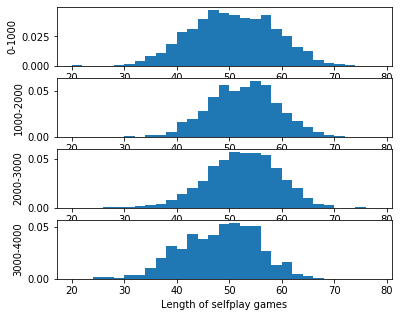

In [5]:
n = (len(results)+999) // 1000
plt.subplots(figsize=(6,5))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.hist(len_games[1000*i:1000*(i+1)], bins=np.arange(20, 80, 2), density=True)
    plt.ylabel(f'{1000*i}-{1000*(i+1)}')
plt.xlabel('Length of selfplay games')
plt.show()

In [6]:
def plot_first_moves(first_moves):
    grid = np.zeros((9,9))
    for move in first_moves:
        grid[move[0], move[1]] += 1
    grid

    grid = torch.tensor(grid).view(3, 3, 3, 3)
    grid = torch.cat(grid.chunk(3, dim=0), dim=2)
    grid = torch.cat(grid.chunk(3, dim=1), dim=3)
    grid = grid.squeeze()
    
    plt.imshow(grid, vmin=0)
    plt.colorbar()

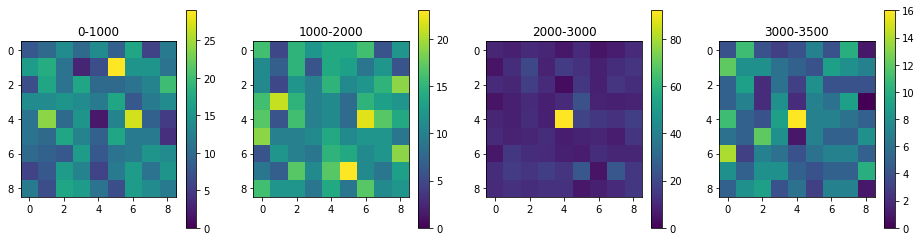

In [7]:
plt.subplots(figsize=(16, 4))
plt.subplot(141)
plot_first_moves(first_moves[:1000])
plt.title('0-1000')
plt.subplot(142)
plot_first_moves(first_moves[1000:2000])
plt.title('1000-2000')
plt.subplot(143)
plot_first_moves(first_moves[2000:3000])
plt.title('2000-3000')
plt.subplot(144)
plot_first_moves(first_moves[3000:3500])
plt.title('3000-3500')
plt.show()

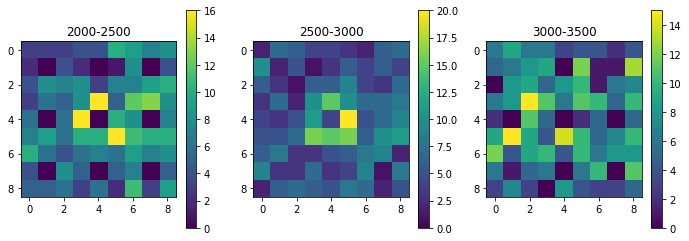

In [9]:
plt.subplots(figsize=(16, 4))
plt.subplot(141)
plot_first_moves(second_moves[2000:2500])
plt.title('2000-2500')
plt.subplot(142)
plot_first_moves(second_moves[2500:3000])
plt.title('2500-3000')
plt.subplot(143)
plot_first_moves(second_moves[3000:3500])
plt.title('3000-3500')
plt.show()

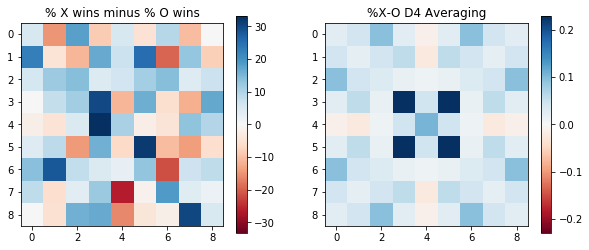

In [10]:
grid = np.zeros((9,9))
gridX = np.zeros((9,9))
gridO = np.zeros((9,9))
for move, r in zip(first_moves, results):
    grid[move[0], move[1]] += 1
    if r == 1:
        gridX[move[0], move[1]] += 1
    elif r == 2:
        gridO[move[0], move[1]] += 1
        
grid2 = (gridX - gridO) / grid
grid2 = torch.tensor(grid2).view(3, 3, 3, 3)
grid2 = torch.cat(grid2.chunk(3, dim=0), dim=2)
grid2 = torch.cat(grid2.chunk(3, dim=1), dim=3)
grid2 = grid2.squeeze()
grid2 *= 100

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(grid2, 
           vmin=-grid2.abs().max(), 
           vmax=grid2.abs().max(),
           cmap='RdBu')
plt.colorbar()
plt.title('% X wins minus % O wins')

##########
       
gridX = torch.tensor(gridX).view(3, 3, 3, 3)
gridX = torch.cat(gridX.chunk(3, dim=0), dim=2)
gridX = torch.cat(gridX.chunk(3, dim=1), dim=3)
gridX = gridX.squeeze()

gridO = torch.tensor(gridO).view(3, 3, 3, 3)
gridO = torch.cat(gridO.chunk(3, dim=0), dim=2)
gridO = torch.cat(gridO.chunk(3, dim=1), dim=3)
gridO = gridO.squeeze()

grid = torch.tensor(grid).view(3, 3, 3, 3)
grid = torch.cat(grid.chunk(3, dim=0), dim=2)
grid = torch.cat(grid.chunk(3, dim=1), dim=3)
grid = grid.squeeze()

gridX = gridX + gridX.transpose(0, 1)
gridX = gridX + gridX.flip(0)
gridX = gridX + gridX.flip(1)
gridX /= 8

gridO = gridO + gridO.transpose(0, 1)
gridO = gridO + gridO.flip(0)
gridO = gridO + gridO.flip(1)
gridO /= 8

grid = grid + grid.transpose(0, 1)
grid = grid + grid.flip(0)
grid = grid + grid.flip(1)
grid /= 8

grid = (gridX - gridO) / grid

plt.subplot(122)
plt.imshow(grid, 
           vmin=-grid.abs().max(), 
           vmax=grid.abs().max(),
           cmap='RdBu')
plt.colorbar()
plt.title('%X-O D4 Averaging')
plt.show()

@3000 D4 averaged %X-O is remarkably consistent:
* Center sector is best. Best to play in corner (or center).
* Playing in center of other sectors is worst because it sends O to the center.
* Playing in corner sectors is better than playing in edge sectors.
* Sending O to the opposite side of the board is worst (perhaps because if current sector is won it does not block where O is sent).

@3500 some changes:
* Center corner much more than center center.
* If playing in corner sector, best to send to another corner not opposite.

# Final states

In [11]:
import sys
sys.path.append('../src')
from engine import BigBoard, bit2board_table

In [13]:
final_boards = []
for i in range(3000, 3500):
    x = np.load(str(i).zfill(5) + '.npz')
    a = BigBoard()
    for m in x['moves']:
        a.move(*m)
    board = [bit2board_table[b] for b in a.bits]
    final_boards.append(np.array(board))
final_boards = np.stack(final_boards)
final_boards = ((final_boards + 1) % 3) - 1
print(final_boards.shape)

(500, 9, 9)


In [14]:
def plot_board(board, symmetric=True, scale_down=False):
    grid = torch.tensor(board).view(3, 3, 3, 3).float()
    grid = torch.cat(grid.chunk(3, dim=0), dim=2)
    grid = torch.cat(grid.chunk(3, dim=1), dim=3)
    grid = grid.squeeze()
    
    if symmetric:
        grid = grid + grid.transpose(0, 1)
        grid = grid + grid.flip(0)
        grid = grid + grid.flip(1)
        grid /= 8

    if scale_down:
        grid /= 1.5
    else:
        grid *= 1.5

    plt.imshow(grid, vmin=-1, vmax=1, cmap='RdBu')

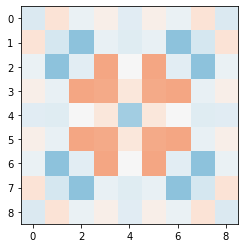

In [15]:
plot_board(np.mean(final_boards, axis=0))

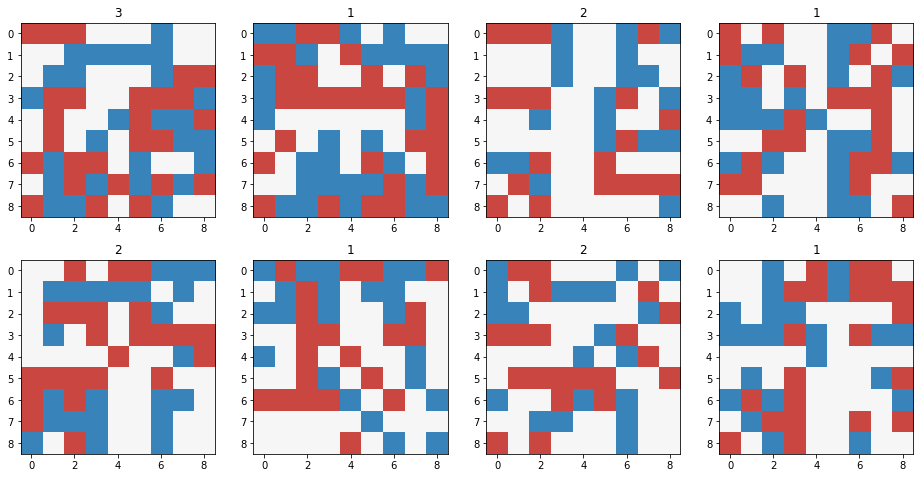

In [16]:
plt.subplots(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plot_board(final_boards[i], symmetric=False, scale_down=True)
    plt.title(results[3000+i])
plt.show()

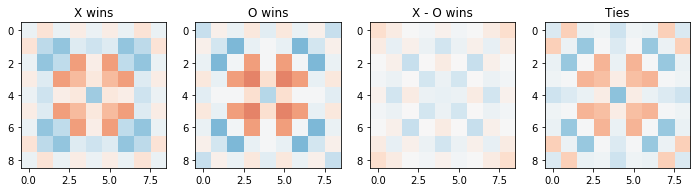

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plot_board(np.mean(final_boards[results[3000:] == 1], axis=0))
plt.title('X wins')
plt.subplot(142)
plot_board(np.mean(final_boards[results[3000:] == 2], axis=0))
plt.title('O wins')
plt.subplot(143)
plot_board(np.mean(final_boards[results[3000:] == 1], axis=0) - \
           np.mean(final_boards[results[3000:] == 2], axis=0))
plt.title('X - O wins')
plt.subplot(144)
plot_board(np.mean(final_boards[results[3000:] == 3], axis=0))
plt.title('Ties')
plt.show()

* The key squares to control are the outside corners of the center sector and the inside corners of the outside corner sectors.
* Also important are the the center tiles of the the edge sectors. 
* Least important (detrimental) are the outside corners of the outside corner sectors.